In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/MNIST/"
dir = "/content/gdrive/My Drive/lab/MNIST/"

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Load data

In [2]:
#if not running on colab, execute this cell
dir = ''

In [3]:
# Train data: 42000 images
train_data = pd.read_csv(dir+"dataset/train.csv")
train_data = train_data.to_numpy(dtype='float32')
x, y = train_data[:,1:], train_data[:,0]
x = x.reshape(x.shape[0], 28, 28, 1)
# Convert labels to one hot encoding
lb = LabelBinarizer()
y = lb.fit_transform(y)

print(x.shape, y.shape)

(42000, 28, 28, 1) (42000, 10)


In [4]:
# Test data: 28000 images
test_data = pd.read_csv(dir+"dataset/testset_with_label.csv")
x_test = test_data.iloc[:,0:784].to_numpy(dtype='float32').reshape((len(test_data),28,28,1))
# get label of the testset
y_test = test_data['Label'].to_numpy()

print(x_test.shape, y_test.shape)

(28000, 28, 28, 1) (28000,)


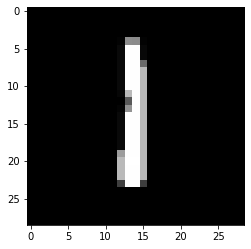

In [42]:
plt.imshow(x[2,:,:,0], cmap='gray')

### Normalize digits' width and pixel value

In [6]:
x = tf.pad(x, tf.constant([[0,0], [0,1], [0,1], [0,0]]))
x_test = tf.pad(x_test, tf.constant([[0,0], [0,1], [0,1], [0,0]]))
print(x.shape)
print(x_test.shape)

(42000, 29, 29, 1)
(28000, 29, 29, 1)


In [7]:
def get_data_with_size(data, normalize_size = 15, target_size = 29):
    assert data.shape[1:3] == (29,29)
    assert normalize_size % 2 == 1 and target_size % 2 == 1
    if normalize_size == target_size:
        return data
    data = tf.image.resize(data, (target_size, normalize_size))
    paddings = (target_size - normalize_size)//2
    data = tf.pad(data, tf.constant([[0,0], [0,0], [paddings,paddings], [0,0]]))
    return data

In [8]:
NORMALIZE_SIZES = [29,27,25,21,17]
data_train = dict()
data_test = dict()
for size in NORMALIZE_SIZES:
    data_train[str(size)] = get_data_with_size(x,size).numpy() / 255.0  #convert to numpy data and normalize value to 0-1
    data_test[str(size)]  = get_data_with_size(x_test,size).numpy() / 255.0
data_train['y'] = y

### Build models:

In [9]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters = 20, kernel_size = (4,4), padding = 'valid', activation ='tanh', input_shape = (29,29,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 40, kernel_size = (5,5), padding = 'valid', activation ='tanh'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Flatten())
    model.add(Dense(150, activation ='tanh'))
    model.add(Dense(10, activation ='softmax'))
    
    return model

In [ ]:
x = data_train[str(21)].numpy()/255.0 #normalize
y = data_train['y']

x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.1)
model = build_model()
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x)
batch_size = 128
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model.fit_generator(datagen.flow(x_train, y_train, batch_size), epochs = 100, steps_per_epoch = x_train.shape[0]//batch_size,
                    validation_data = (x_dev, y_dev), callbacks=[annealer], verbose=2)

In [ ]:
model.save(dir+'/models/first_model.hdf5')

### Train models:

In [ ]:
models = dict()
for normalize_size in NORMALIZE_SIZES[1:]:
    for column in range(0,4):
        model_name = f'{normalize_size}_{column}'
        # prepare data
        x = data[str(normalize_size)].numpy()/255.0
        y = data['y']
        x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.1)

        # data augmentation
        datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)

        # callbacks
        annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x)
        logger = CSVLogger(dir+'/models/training_history/'+model_name+'.csv', append=True)

        # define some params
        batch_size = 128
        epochs = 100

        # start training
        model = build_model()
        model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
        model.fit_generator(datagen.flow(x_train, y_train, batch_size), epochs=epochs, steps_per_epoch = x_train.shape[0]//batch_size,
                            validation_data=(x_dev, y_dev), validation_freq=1, callbacks=[annealer, logger], verbose=0)
        
        models['model_name'] = model
        #save model
        model.save(dir+'/models/'+model_name+'.hdf5')

### Evaluate 

In [10]:
# load models
models = dict()
for model_name in os.listdir(dir+'models/'):
    model = load_model(dir+'models/'+model_name)
    model_id = model_name[:-5]
    models[model_id] = model

In [11]:
def predict(models, x):
    """
    Input:
        models: a dict of models that was trained and loaded above
        x: a dict of transformed testsets (#n, h, w, channels)
    Return:
        predictions: a dict of predictions made by individual nets and multi-column nets
    """
    predictions = dict()
    all_net_sum = 0

    for normalize_size in NORMALIZE_SIZES:
        four_net_sum = 0
        for column in range(4):
            model_id = f'{normalize_size}_{column}'
            column_val = models[model_id].predict(x[str(normalize_size)])
            predictions[model_id] = np.argmax(column_val, axis=1)

            four_net_sum += column_val
            all_net_sum += column_val

        four_net_avg = four_net_sum / 4 # take 4-column average
        predictions[str(normalize_size)] = np.argmax(four_net_avg, axis=1)

    all_net_avg = all_net_sum / len(models)
    predictions['avg'] = np.argmax(all_net_avg, axis=1) # take average of all models
    
    return predictions

In [12]:
def error_rate(prediction, ground_truth):
    assert len(prediction) == len(ground_truth)
    a = accuracy_score(prediction, ground_truth)
    e = 1-a
    return f'{e*100:.2f}%' #string format .2f %

In [24]:
predictions = predict(models, data_test)

In [25]:
for model_id, pred in predictions.items():
    print(model_id, error_rate(pred, y_test))

29_0 0.72%
29_1 0.69%
29_2 0.64%
29_3 0.59%
29 0.48%
27_0 0.59%
27_1 0.64%
27_2 0.64%
27_3 0.65%
27 0.45%
25_0 0.58%
25_1 0.58%
25_2 0.73%
25_3 0.56%
25 0.45%
21_0 0.66%
21_1 0.61%
21_2 0.72%
21_3 0.71%
21 0.48%
17_0 0.71%
17_1 0.60%
17_2 0.59%
17_3 0.70%
17 0.48%
avg 0.40%


### Weighted ensemble: <br>
- Output of the MCDNN: (batch, n_class, n_column, n_channel) = (n, 10, 20, 1)
- simple ensembler optimizes weights for each column
- more complex ensembler optimizes weights for each unit in columns
- the ensembler sum up all columns with their weights and apply softmax function which results in output with shape (n,10)

In [13]:
# Create data for training weights for each model
def get_model_outputs(models, x):
    """
    Input:
        models: a dict of models that was trained and loaded above
        x: a dict of transformed testsets (#n, h, w, channels)
    Return:
        outputs: 20 columns get stacked together (#n, 10, 20, 1) and a dict maping model_id to column id
    """
    outputs = np.zeros((x['29'].shape[0],10,20,1), dtype='float32')
    model_to_column = dict()
    
    i = 0
    for normalize_size in NORMALIZE_SIZES:
        for column in range(4):
            model_id = f'{normalize_size}_{column}'
            column_val = models[model_id].predict(x[str(normalize_size)])
            outputs[:,:,i,0] = column_val
            model_to_column[model_id] = i
            i += 1
            
    return (outputs, model_to_column)

In [14]:
columns, model_to_columnId = get_model_outputs(models, data_train)
columns.shape

(42000, 10, 20, 1)

In [15]:
def train_ensembler(x, y):
    """
    x: outputs of 20 models (42000,10,20,1)
    y: label (42000,10)
    return: weights for models
    """
    # prepare data
    x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.2, random_state=42)
    
    ensembler = Sequential()
    ensembler.add(Conv2D(filters=1, kernel_size=(1,20), padding='valid', input_shape=(10,20,1)))
    ensembler.add(Flatten())
    ensembler.add(Activation('softmax'))
    
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    ensembler.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    ensembler.fit(x=x_train, y=y_train, epochs=42, batch_size=256, validation_data=(x_dev, y_dev), callbacks=[annealer], verbose=2)
    
    return ensembler

In [18]:
ensembler1 = train_ensembler(columns, y)

Train on 33600 samples, validate on 8400 samples
Epoch 1/42
 - 1s - loss: 1.8673 - accuracy: 0.7166 - val_loss: 0.9511 - val_accuracy: 0.9990
Epoch 2/42
 - 1s - loss: 0.5555 - accuracy: 0.9993 - val_loss: 0.3051 - val_accuracy: 0.9993
Epoch 3/42
 - 0s - loss: 0.2133 - accuracy: 0.9993 - val_loss: 0.1477 - val_accuracy: 0.9995
Epoch 4/42
 - 0s - loss: 0.1163 - accuracy: 0.9994 - val_loss: 0.0905 - val_accuracy: 0.9996
Epoch 5/42
 - 1s - loss: 0.0763 - accuracy: 0.9994 - val_loss: 0.0630 - val_accuracy: 0.9996
Epoch 6/42
 - 0s - loss: 0.0554 - accuracy: 0.9994 - val_loss: 0.0473 - val_accuracy: 0.9995
Epoch 7/42
 - 0s - loss: 0.0429 - accuracy: 0.9994 - val_loss: 0.0374 - val_accuracy: 0.9995
Epoch 8/42
 - 0s - loss: 0.0347 - accuracy: 0.9994 - val_loss: 0.0306 - val_accuracy: 0.9995
Epoch 9/42
 - 1s - loss: 0.0290 - accuracy: 0.9994 - val_loss: 0.0258 - val_accuracy: 0.9995
Epoch 10/42
 - 1s - loss: 0.0249 - accuracy: 0.9994 - val_loss: 0.0222 - val_accuracy: 0.9995
Epoch 11/42
 - 1s - 

In [19]:
weights = ensembler1.get_layer(index=0).get_weights()
print(weights)

[array([[[[0.5282702 ]],

        [[0.34110475]],

        [[0.79952043]],

        [[0.57873416]],

        [[0.6989094 ]],

        [[0.32333928]],

        [[0.5689375 ]],

        [[0.13514563]],

        [[0.1143741 ]],

        [[0.79800946]],

        [[0.47129872]],

        [[0.2930282 ]],

        [[0.4485501 ]],

        [[0.33545163]],

        [[0.3575827 ]],

        [[0.05459918]],

        [[0.25592005]],

        [[0.19542356]],

        [[0.05737453]],

        [[0.8009204 ]]]], dtype=float32), array([0.00027843], dtype=float32)]


In [36]:
def train_complex_ensembler(x, y):
    # prepare data
    x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.2, random_state=42)
    
    ensembler = Sequential()
    ensembler.add(Conv2D(filters=10, kernel_size=(1,20), padding='valid', input_shape=(10,20,1), activation='relu'))
    ensembler.add(Conv2D(filters=1, kernel_size=(1,1), padding='valid'))
    ensembler.add(Flatten())
    ensembler.add(Activation('softmax'))
    
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    ensembler.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    ensembler.fit(x=x_train, y=y_train, epochs=30, batch_size=256, validation_data=(x_dev, y_dev), callbacks=[annealer], verbose=2)
    
    return ensembler

In [37]:
ensembler2 = train_complex_ensembler(columns, y)

Train on 33600 samples, validate on 8400 samples
Epoch 1/30
 - 1s - loss: 1.0274 - accuracy: 0.9994 - val_loss: 0.2151 - val_accuracy: 0.9999
Epoch 2/30
 - 1s - loss: 0.0939 - accuracy: 0.9994 - val_loss: 0.0398 - val_accuracy: 0.9999
Epoch 3/30
 - 1s - loss: 0.0279 - accuracy: 0.9994 - val_loss: 0.0178 - val_accuracy: 0.9999
Epoch 4/30
 - 1s - loss: 0.0152 - accuracy: 0.9994 - val_loss: 0.0106 - val_accuracy: 0.9999
Epoch 5/30
 - 1s - loss: 0.0103 - accuracy: 0.9994 - val_loss: 0.0073 - val_accuracy: 0.9999
Epoch 6/30
 - 1s - loss: 0.0079 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9999
Epoch 7/30
 - 1s - loss: 0.0066 - accuracy: 0.9994 - val_loss: 0.0044 - val_accuracy: 0.9999
Epoch 8/30
 - 1s - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 0.9999
Epoch 9/30
 - 1s - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0010 - val_accuracy: 0.9999
Epoch 10/30
 - 1s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 9.4654e-04 - val_accuracy: 0.9999
Epoch 11/30
 - 1

In [32]:
ensembler2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 1, 10)         210       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 1, 1)          11        
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


### Evaluate ensembler on testset:

In [20]:
testset_columns, _ = get_model_outputs(models, data_test)

In [22]:
pred = ensembler1.predict(testset_columns)
pred = np.argmax(pred, axis=1)
error_rate(pred, y_test)

'0.39%'

In [39]:
pred = ensembler2.predict(testset_columns)
pred = np.argmax(pred, axis=1)
error_rate(pred, y_test)

'0.38%'